# Exploring AI Mentions in Earnings Calls and Building Thematic Portfolios

## Introduction

In recent years, artificial intelligence (AI) has emerged as a central pillar of innovation across various industries. As companies increasingly emphasize AI in their business strategies, earnings calls have become an important source of insights for investors seeking to understand corporate priorities and market trends.

This article examines how the frequency and sentiment of AI mentions in earnings calls have evolved over time and whether these patterns can indicate a company's long-term growth potential. To uncover these insights, we conducted an exploratory analysis of earnings call transcripts from companies across diverse sectors leveraging LSEG MarketPsych Transcripts Analytics (MTA)  API. Additionally, we developed thematic portfolios based on these insights and tracked their historical performance to assess whether investing in AI-focused companies can yield significant returns.

The article is structured into three sections: setting up the dataset, conducting exploratory analysis, and building thematic portfolios.

## Import relevent libraries

To start, we first install and import the necessary packages. We use the [Refinitiv Data Libraries](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python) to retrieve the company universe for the analyis and [LSEG MarketPsych Transcripts Analytics (MTA)](https://www.marketpsych.com/transcripts/guide/overview) API for earnings transcripts. The code is built using Python 3.9. The prerequisite packages are imported as shown below. Please make sure you have them installed.

In [1]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import refinitiv.data as rd
from refinitiv.data.discovery import convert_symbols, SymbolTypes
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

rd.get_config()["http.request-timeout"] = 60
pd.options.display.max_columns = None

## Section 1: Setting up the dataset

### Getting the company universe for the analysis

The first step is to define the universe of companies for which we will request transcript data from MTA. For a robust analysis, it's important to include a large number of companies across various economic sectors. Therefore, we have chosen the constituents of the [Russell 1000]((https://www.lseg.com/en/ftse-russell/indices/russell-us/russell-1000)) index as our universe, which encompasses all large-cap companies in the US.

Since our primary objective is to conduct an exploratory analysis rather than develop a comprehensive portfolio construction strategy, we will use the current list of Russell 1000 constituents. For a more in-depth analysis of portfolio performance, it is advisable to track changes in index constituents over time (e.g., each quarter). In this regard, [this article](https://developers.lseg.com/en/article-catalog/article/building-historical-index-constituents) provides useful functions for retrieving historical index constituent data.

To begin, we open an API session and request the data for the universe of companies using RD Libraries for Python. Additionally, to implement also a sectoral analysis, we request information on the economic sectors of these companies.

In [2]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x103c8c430 {name='workspace'}>

In [3]:
universe = rd.get_data('0#.RUI', 'TR.TRBCEconomicSector')
universe

Instrument TRBC Economic Sector Name
0         AIZ.N                Financials
1         GME.N        Consumer Cyclicals
2        KEYS.N                Technology
3       QCOM.OQ                Technology
4        KMPR.N                Financials
...         ...                       ...
1005      NLY.N               Real Estate
1006       MA.N                Technology
1007    BIIB.OQ                Healthcare
1008      SYF.N                Financials
1009     OZK.OQ                Financials

[1010 rows x 2 columns]

The request above returned the RICs of the FTSE 1000 contituent companies alongside with the economic sectors they represent. To request the transcripts data via MTA though, we need to use company perm_ids, therefore we leverage symbology conversion of the RD Libraries to get the perm_ids of our universe.

In [4]:
universe_rics = universe['Instrument'].to_list()

universe_perm_ids = convert_symbols(universe_rics, 
    from_symbol_type=SymbolTypes.RIC,
    to_symbol_types=[SymbolTypes.OA_PERM_ID],
)

universe_perm_ids

DocumentTitle IssuerOAPermID
AIZ.N    Assurant Inc, Ordinary Share, New York Stock E...     4295899478
GME.N    GameStop Corp, Ordinary Share, Class A, New Yo...     4295902037
KEYS.N   Keysight Technologies Inc, Ordinary Share, New...     5041978269
QCOM.OQ  Qualcomm Inc, Ordinary Share, NASDAQ Stock Exc...     4295907706
KMPR.N   Kemper Corp, Ordinary Share, New York Stock Ex...     4295908262
...                                                    ...            ...
NLY.N    Annaly Capital Management Inc, Ordinary Share,...     4295903438
MA.N     Mastercard Inc, Ordinary Share, Class A, New Y...     4295902520
BIIB.OQ  Biogen Inc, Ordinary Share, NASDAQ Stock Excha...     4295906748
SYF.N    Synchrony Financial, Ordinary Share, New York ...     5042214022
OZK.OQ   Bank Ozk, Ordinary Share, NASDAQ Stock Exchang...     4296474683

[1010 rows x 2 columns]

Now let's merge the requested perm_ids with our initial universe.

In [5]:
universe_perm_ids.drop_duplicates(subset = 'IssuerOAPermID', inplace =True)
universe = universe.merge(universe_perm_ids, left_on='Instrument', right_index=True)
universe

Instrument TRBC Economic Sector Name  \
0         AIZ.N                Financials   
1         GME.N        Consumer Cyclicals   
2        KEYS.N                Technology   
3       QCOM.OQ                Technology   
4        KMPR.N                Financials   
...         ...                       ...   
1005      NLY.N               Real Estate   
1006       MA.N                Technology   
1007    BIIB.OQ                Healthcare   
1008      SYF.N                Financials   
1009     OZK.OQ                Financials   

                                          DocumentTitle IssuerOAPermID  
0     Assurant Inc, Ordinary Share, New York Stock E...     4295899478  
1     GameStop Corp, Ordinary Share, Class A, New Yo...     4295902037  
2     Keysight Technologies Inc, Ordinary Share, New...     5041978269  
3     Qualcomm Inc, Ordinary Share, NASDAQ Stock Exc...     4295907706  
4     Kemper Corp, Ordinary Share, New York Stock Ex...     4295908262  
...                                                 ...            ...  
1005  Annaly Capital Management Inc, Ordinary Share,...     4295903438  
1006  Mastercard Inc, Ordinary Share, Class A, New Y...     4295902520  
1007  Biogen Inc, Ordinary Share, NASDAQ Stock Excha...     4295906748  
1008  Synchrony Financial, Ordinary Share, New York ...     5042214022  
1009  Bank Ozk, Ordinary Share, NASDAQ Stock Exchang...     4296474683  

[992 rows x 4 columns]

### Getting the transcripts for our universe

Once we have our universe defined, let's request the transcripts data useing MTA API. The API allows single and multi-asset ingestion and offers document, sector, speaker and sentence level of request granularity. In the scope of our analysis, we will go for multi-asset sentence level request. Furthermore, we will benefit from the searching capabilities of the API and ask only for sentences containing word AI. More about the MTA API and it's capabilities can be found in the [official documentation](https://www.marketpsych.com/transcripts/guide/overview).


Before making our request though, below we provide a wrapper function that simplifies the process of fetching data from the API and by directly loading it into a pandas DataFrame.

In [6]:
def create_df(url: str) -> pd.DataFrame:
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Query failed with status code {response.status_code}: {response.json().get('error')}")
    data = response.json()['data']
    return pd.DataFrame(data)

In [7]:
def chunk_list(lst: list, chunk_size: int) -> list:
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

To begin, you'll need to replace APIKEY in the code snippet below with your API key provided by LSEG/MarketPsych. Further, we define the remaining request parameters and leverage the function above for the chunks of our universe. We devide our original universe into chunks to respect the API limits uning chunk_list function introduced below.

In [8]:
APIKEY = "" # Replace the following with your API key

chunk_size = 500
perm_ids_chunks = list(chunk_list(universe['IssuerOAPermID'], chunk_size))

start_date = '2016-01-01'
end_date = '2024-06-03'
search_word = 'AI'

events_df = pd.DataFrame()

for perm_ids in perm_ids_chunks:
    perm_ids_str = ','.join(perm_ids)
    url = f"https://dataapi.marketpsych.com/mta/data/{perm_ids_str}?apikey={APIKEY}&aggregation_type=sentence&start_date={start_date}&end_date={end_date}&event_type=ecc&dedup=True&search={search_word}&format=json"
    df = create_df(url)
    events_df = pd.concat([events_df, df])
events_df

_id  \
0      26abbeefff5e6b4b07f5b8e9bb91f168_q-and-a_24_ma...   
1      26abbeefff5e6b4b07f5b8e9bb91f168_q-and-a_25_de...   
2      26abbeefff5e6b4b07f5b8e9bb91f168_q-and-a_25_de...   
3      65f5e52dc2cad1e9f691e7bfcde0c3c2_q-and-a_68_da...   
4      65f5e52dc2cad1e9f691e7bfcde0c3c2_q-and-a_68_da...   
...                                                  ...   
15146  0a5d615bb8de9976d23874d45100265b_q-and-a_37_sh...   
15147  0a5d615bb8de9976d23874d45100265b_q-and-a_38_ja...   
15148  0a5d615bb8de9976d23874d45100265b_q-and-a_38_ja...   
15149  0a5d615bb8de9976d23874d45100265b_q-and-a_54_ad...   
15150  0a5d615bb8de9976d23874d45100265b_q-and-a_55_ja...   

                            document.id document.status  document.last_edited  \
0      26abbeefff5e6b4b07f5b8e9bb91f168          EDITED   2016-07-20T22:52:23   
1      26abbeefff5e6b4b07f5b8e9bb91f168          EDITED   2016-07-20T22:52:23   
2      26abbeefff5e6b4b07f5b8e9bb91f168          EDITED   2016-07-20T22:52:23   
3      65f5e52dc2cad1e9f691e7bfcde0c3c2          EDITED   2016-11-15T15:17:07   
4      65f5e52dc2cad1e9f691e7bfcde0c3c2          EDITED   2016-11-15T15:17:07   
...                                 ...             ...                   ...   
15146  0a5d615bb8de9976d23874d45100265b          EDITED  2024-05-31T20:36:10Z   
15147  0a5d615bb8de9976d23874d45100265b          EDITED  2024-05-31T20:36:10Z   
15148  0a5d615bb8de9976d23874d45100265b          EDITED  2024-05-31T20:36:10Z   
15149  0a5d615bb8de9976d23874d45100265b          EDITED  2024-05-31T20:36:10Z   
15150  0a5d615bb8de9976d23874d45100265b          EDITED  2024-05-31T20:36:10Z   

                              event.name event.type     event.start_date  \
0         Q2 2016 eBay Inc Earnings Call        ecc  2016-07-20T21:00:00   
1         Q2 2016 eBay Inc Earnings Call        ecc  2016-07-20T21:00:00   
2         Q2 2016 eBay Inc Earnings Call        ecc  2016-07-20T21:00:00   
3      Q3 2016 Expedia Inc Earnings Call        ecc  2016-10-27T20:30:00   
4      Q3 2016 Expedia Inc Earnings Call        ecc  2016-10-27T20:30:00   
...                                  ...        ...                  ...   
15146  Q3 2024 Zscaler Inc Earnings Call        ecc  2024-05-30T20:30:00   
15147  Q3 2024 Zscaler Inc Earnings Call        ecc  2024-05-30T20:30:00   
15148  Q3 2024 Zscaler Inc Earnings Call        ecc  2024-05-30T20:30:00   
15149  Q3 2024 Zscaler Inc Earnings Call        ecc  2024-05-30T20:30:00   
15150  Q3 2024 Zscaler Inc Earnings Call        ecc  2024-05-30T20:30:00   

      event.reference_date   event.host event.host_permid       company.name  \
0      2016-06-30T00:00:00     eBay Inc        4295906238           eBay Inc   
1      2016-06-30T00:00:00     eBay Inc        4295906238           eBay Inc   
2      2016-06-30T00:00:00     eBay Inc        4295906238           eBay Inc   
3      2016-09-30T00:00:00  Expedia Inc        4295899731  Expedia Group Inc   
4      2016-09-30T00:00:00  Expedia Inc        4295899731  Expedia Group Inc   
...                    ...          ...               ...                ...   
15146  2024-09-30T00:00:00  Zscaler Inc        5036689323        Zscaler Inc   
15147  2024-09-30T00:00:00  Zscaler Inc        5036689323        Zscaler Inc   
15148  2024-09-30T00:00:00  Zscaler Inc        5036689323        Zscaler Inc   
15149  2024-09-30T00:00:00  Zscaler Inc        5036689323        Zscaler Inc   
15150  2024-09-30T00:00:00  Zscaler Inc        5036689323        Zscaler Inc   

      company.permid company.ric company.ticker section.name section.type  \
0         4295906238     EBAY.OQ           EBAY      q-and-a       report   
1         4295906238     EBAY.OQ           EBAY      q-and-a       report   
2         4295906238     EBAY.OQ           EBAY      q-and-a       report   
3         4295899731     EXPE.OQ           EXPE      q-and-a       report   
4         4295899731     EXPE.OQ           EXPE      q-and-a       report   
...              ...   

The resulting dataframe includes around 28,000 sentences from our universe, dating back to January 2016. It encompasses a broad range of emotion and sentiment metrics for each sentence. Additionally, each entry is provided with metadata related to the event, company, and speaker. A complete list of the output fields and their descriptions is available in the [documentation](https://www.marketpsych.com/transcripts/guide/fields). 

To make our final dataset ready for the analysis, we merge the transcripts data above with the universe data we obtained in the previous section and sort the values by the start date of the event.

In [9]:
events_df['company.permid'] = events_df['company.permid'].astype(str)
events_df = events_df.merge(universe, left_on = 'company.permid', right_on='IssuerOAPermID', how='inner')
events_df['start_date'] = pd.to_datetime(events_df['event.start_date']).dt.date
events_df = events_df.sort_values(by='start_date')
events_df

_id  \
26761  27802443a70d9e0f251ef41cb1cc33bc_q-and-a_71_je...   
26762  27802443a70d9e0f251ef41cb1cc33bc_q-and-a_76_ha...   
26763  27802443a70d9e0f251ef41cb1cc33bc_q-and-a_76_ha...   
26764  27802443a70d9e0f251ef41cb1cc33bc_q-and-a_76_ha...   
26760  27802443a70d9e0f251ef41cb1cc33bc_q-and-a_31_da...   
...                                                  ...   
7464   2230d6cc7af5758dee354274af96141c_q-and-a_2_kri...   
7465   2230d6cc7af5758dee354274af96141c_q-and-a_30_am...   
7466   2230d6cc7af5758dee354274af96141c_q-and-a_33_si...   
24909  c9311a769a6d568ce1159bef157ca24d_presentation_...   
7413   2230d6cc7af5758dee354274af96141c_presentation_...   

                            document.id document.status  document.last_edited  \
26761  27802443a70d9e0f251ef41cb1cc33bc          EDITED   2016-02-08T18:33:03   
26762  27802443a70d9e0f251ef41cb1cc33bc          EDITED   2016-02-08T18:33:03   
26763  27802443a70d9e0f251ef41cb1cc33bc          EDITED   2016-02-08T18:33:03   
26764  27802443a70d9e0f251ef41cb1cc33bc          EDITED   2016-02-08T18:33:03   
26760  27802443a70d9e0f251ef41cb1cc33bc          EDITED   2016-02-08T18:33:03   
...                                 ...             ...                   ...   
7464   2230d6cc7af5758dee354274af96141c          EDITED  2024-05-31T07:16:34Z   
7465   2230d6cc7af5758dee354274af96141c          EDITED  2024-05-31T07:16:34Z   
7466   2230d6cc7af5758dee354274af96141c          EDITED  2024-05-31T07:16:34Z   
24909  c9311a769a6d568ce1159bef157ca24d          EDITED  2024-05-30T17:01:12Z   
7413   2230d6cc7af5758dee354274af96141c          EDITED  2024-05-31T07:16:34Z   

                                        event.name event.type  \
26761          Q4 2015 Celanese Corp Earnings Call        ecc   
26762          Q4 2015 Celanese Corp Earnings Call        ecc   
26763          Q4 2015 Celanese Corp Earnings Call        ecc   
26764          Q4 2015 Celanese Corp Earnings Call        ecc   
26760          Q4 2015 Celanese Corp Earnings Call        ecc   
...                                            ...        ...   
7464   Q1 2025 Dell Technologies Inc Earnings Call        ecc   
7465   Q1 2025 Dell Technologies Inc Earnings Call        ecc   
7466   Q1 2025 Dell Technologies Inc Earnings Call        ecc   
24909        Q1 2025 Best Buy Co Inc Earnings Call        ecc   
7413   Q1 2025 Dell Technologies Inc Earnings Call        ecc   

          event.start_date event.reference_date             event.host  \
26761  2016-01-22T15:00:00  2015-12-31T00:00:00          Celanese Corp   
26762  2016-01-22T15:00:00  2015-12-31T00:00:00          Celanese Corp   
26763  2016-01-22T15:00:00  2015-12-31T00:00:00          Celanese Corp   
26764  2016-01-22T15:00:00  2015-12-31T00:00:00          Celanese Corp   
26760  2016-01-22T15:00:00  2015-12-31T00:00:00          Celanese Corp   
...                    ...                  ...                    ...   
7464   2024-05-30T20:30:00  2025-03-31T00:00:00  Dell Technologies Inc   
7465   2024-05-30T20:30:00  2025-03-31T00:00:00  Dell Technologies Inc   
7466   2024-05-30T20:30:00  2025-03-31T00:00:00  Dell Technologies Inc   
24909  2024-05-30T12:00:00  2025-03-31T00:00:00        Best Buy Co Inc   
7413   2024-05-30T20:30:00  2025-03-31T00:00:00  Dell Technologies Inc   

      event.host_permid           company.name company.permid company.ric  \
26761        4295899696          Celanese Corp     4295899696        CE.N   
26762        4295899696          Celanese Corp     4295899696        CE.N   
26763        4295899696          Celanese Corp     4295899696        CE.N   
26764        4295899696          Celanese Corp     4295899696        CE.N   
26760        4295899696          Celanese Corp     4295899696        CE.N   
...                 ...                    ...            ...         ...   
7464         5040186364  Dell Technologies Inc     5040186364      DELL.N   
7465         5040186364  Dell Technologies Inc     5040186364      DELL.N

## Section 2: Exploring AI Mentions trends across time and sectors
In this section we provide an analysis of AI mentions in earnings calls, focusing on both temporal and sectoral trends. With various plots we demonstrate how the frequency and emotions of AI-related sentences in the transcripts have evolved over time and how these patterns vary across different industries and companies. To scale the analysis we define reusable functions for grouping our initial dataset and producing the plots.

### Defining helper functions
First, we define a function to group our dataset. The ***group_dataset*** function below processes a DataFrame to perform aggregation and analysis based on specified columns passed as an input. 

In [10]:
def group_dataset(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    # Columns to average
    mean_columns = [
        'analysis.fin_sentiment',
        'analysis.esg_sentiment', 'emotions.admiration', 'emotions.anger',
        'emotions.annoyance', 'emotions.approval', 'emotions.confusion',
        'emotions.disappointment', 'emotions.disapproval', 'emotions.fear',
        'emotions.gratitude', 'emotions.optimism', 'emotions.pride',
        'emotions.surprise', 'emotions.neutral'
    ]

    # Aggregation functions for grouping
    aggregation_functions = {col: 'mean' for col in mean_columns}
    aggregation_functions['sentence.idx'] = 'count'
    aggregation_functions['company.permid'] = 'nunique'

    # Convert 'start_date' to datetime and create 'quarter' column
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['quarter'] = df['start_date'].dt.to_period('Q')

    # Group by specified columns and aggregate
    grouped = df.groupby(cols).agg(aggregation_functions).reset_index()

    # Rename columns for clarity
    grouped.rename(columns={'sentence.idx': 'num_sentences', 'company.permid': 'company_count'}, inplace=True)

    # Sort by 'quarter' and reset index
    return grouped.sort_values(by='quarter').reset_index(drop=True)


Next, we define our plotting functions which will be used to produce different plots for provided metrics, sectors and companies. 

The function below produces a plot that visualizes changes in both the number of sentences and aggregated metrics, such as emotions and sentiments, across each quarter. It creates line plots for each metric provided in the input list, allowing for a detailed examination of how these metrics evolve over time. Additionally, it includes a bar plots to represent the number of sentences and the number of companies mentioning AI in their transcripts per quarter.

In [11]:
def plot_metric_and_sentence_trends(data: pd.DataFrame, metrics_to_plot: list, show_company_count: bool = False, name: str = 'all'):
    # Extract quarters as strings
    quarters = data['quarter'].astype(str)
    
    # Initialize subplot figure
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=False,
                        vertical_spacing=0.15,
                        row_width=[0.5, 1],
                        specs=[[{'secondary_y': True}], [{}]])

    # Add metrics traces
    for metric in metrics_to_plot:
        fig.add_trace(
            go.Scatter(x=quarters, y=data[metric], name=metric.split('.')[1], mode='lines+markers'),
            row=1, col=1, secondary_y=False
        )
    
    # Add sentence count trace
    fig.add_trace(
        go.Bar(x=quarters, y=data['num_sentences'], name='Sentence Count', opacity=0.6),
        row=1, col=1, secondary_y=True
    )
    fig.update_layout(yaxis_title='Emotion Score', height=800, title=f'Quarterly Emotion Trends for {name}')
    
    # Optionally add company count trace
    if show_company_count:
        fig.add_trace(
            go.Bar(x=quarters, y=data['company_count'], name='Company Count', marker_color='orange'),
            row=2, col=1
        )
        fig.update_yaxes(title_text="Sentence Count", secondary_y=True, row=1, col=1)
        fig.update_yaxes(title_text="Company Count", row=2, col=1)

    fig.show()


The function below generates two pie charts for visualizing the sectoral distribution of data. The first pie chart illustrates the distribution of the number of sentences across different economic sectors. The second pie chart represents the sectoral distribution of a specified emotion metric, allowing for the comparison of emotional content across sectors. 

In [12]:
def plot_sectoral_analysis(data: pd.DataFrame, metric: str):
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]])

    fig.add_trace(
        go.Pie(labels=data['TRBC Economic Sector Name'], 
            values=data['num_sentences'],
            name='Number of sentences'),
        row=1, col=1
    )

    fig.add_trace(
        go.Pie(labels=data['TRBC Economic Sector Name'], 
            values=data[metric], 
            name=f"{metric.split('.')[1]}"),
        row=1, col=2
    )

    fig.update_layout(
        width=1000,
        height=500,
        annotations=[
            dict(text='Number of sentences', x=0.1, xref='paper', y=1.15, yref='paper', showarrow=False, font=dict(size=16)),
            dict(text=f"{metric.split('.')[1]}".capitalize(), x=0.8, xref='paper', y=1.15, yref='paper', showarrow=False, font=dict(size=16))
        ]
    )

    fig.show()


Finally the ***plot_sector_area_trend*** function generates an area chart that displays the historical trends of a specified metric across different economic sectors, organized by quarters througout the analyis period. While the previous function shows the aggregated sectoral distribution point in time, this function allows to explore how the sectoral distribution of the metric evolved over time.

In [13]:
def plot_sector_area_trend(data: pd.DataFrame, metric: str):
    data['quarter'] = data['quarter'].astype(str)
    fig = px.area(data, x = 'quarter',
                 y=metric, color="TRBC Economic Sector Name", width=1400, height=600)

    fig.update_layout(
        xaxis=dict(
            type='category',
            categoryorder='array',
        ),
        title = 'Number of constituents per sector historically',
        width=1000, height=500
    )
    fig.show()

### Aggregated view of the analysis

Below we group our initial dataset by quarter only, which will enable the aggregated view of the trends in AI mentions, related emotions and sentiments. We use previously defined ***group_dataset*** function as shown below:

In [14]:
group_cols = ['quarter']
events_by_quarter  = group_dataset(events_df, group_cols)
events_by_quarter

quarter  analysis.fin_sentiment  analysis.esg_sentiment  \
0   2016Q1                0.317812                0.375000   
1   2016Q2                0.476316                0.702308   
2   2016Q3                0.391481                0.254167   
3   2016Q4                0.473617                0.535179   
4   2017Q1                0.593879                0.651379   
5   2017Q2                0.516276                0.563776   
6   2017Q3                0.613707                0.591743   
7   2017Q4                0.608773                0.616000   
8   2018Q1                0.643182                0.481111   
9   2018Q2                0.578549                0.622209   
10  2018Q3                0.631003                0.636346   
11  2018Q4                0.699860                0.689250   
12  2019Q1                0.711152                0.705556   
13  2019Q2                0.634849                0.660132   
14  2019Q3                0.687709                0.615593   
15  2019Q4                0.638741                0.703286   
16  2020Q1                0.740368                0.692500   
17  2020Q2                0.765243                0.649496   
18  2020Q3                0.751536                0.672185   
19  2020Q4                0.711717                0.689381   
20  2021Q1                0.736054                0.732228   
21  2021Q2                0.710753                0.681516   
22  2021Q3                0.752917                0.755877   
23  2021Q4                0.688662                0.672708   
24  2022Q1                0.737741                0.684662   
25  2022Q2                0.737162                0.714184   
26  2022Q3                0.677445                0.680198   
27  2022Q4                0.734436                0.696457   
28  2023Q1                0.639888                0.587701   
29  2023Q2                0.581330                0.576981   
30  2023Q3                0.599409                0.621124   
31  2023Q4                0.628302                0.636333   
32  2024Q1                0.617036                0.626051   
33  2024Q2                0.641733                0.658710   

    emotions.admiration  emotions.anger  emotions.annoyance  \
0              0.022812        0.000937            0.020313   
1              0.025526        0.003158            0.013158   
2              0.073704        0.003704            0.019630   
3              0.048582        0.009504            0.019220   
4              0.055517        0.001638            0.014655   
5              0.036327        0.003010            0.024286   
6              0.056098        0.001024            0.010634   
7              0.040409        0.002545            0.010500   
8              0.035818        0.001273            0.008500   
9              0.051609        0.001262            0.016498   
10             0.050346        0.000796            0.013841   
11             0.048605        0.000744            0.012186   
12             0.040864        0.001399            0.013086   
13             0.045151        0.002007            0.007324   
14             0.032755        0.003932            0.015882   
15             0.033007        0.001923            0.018322   
16             0.046765        0.000956            0.008824   
17             0.040291        0.000583            0.006796   
18             0.045131        0.001948            0.011086   
19             0.040960        0.000985            0.009899   
20             0.052081        0.001514            0.007541   
21             0.053767        0.001438            0.015502   
22             0.048309        0.002721            0.006422   
23             0.054953        0.001103            0.007559   
24             0.053975        0.000921            0.010628   
25             0.055789        0.001190            0.010114   
26             0.061179        0.001528            0.014716   
27             0.043564        0.001872            0.007410   
28   

As we now have the event dataset grouped by quarter, we pass it to ***plot_metric_and_sentence_trends*** function along with the metrics column to produce a visualisation showing the changes in AI mentions and emotions around it over time. We also define the metrics we are interested in below, which you can change with other metrics available in the grouped dataset.

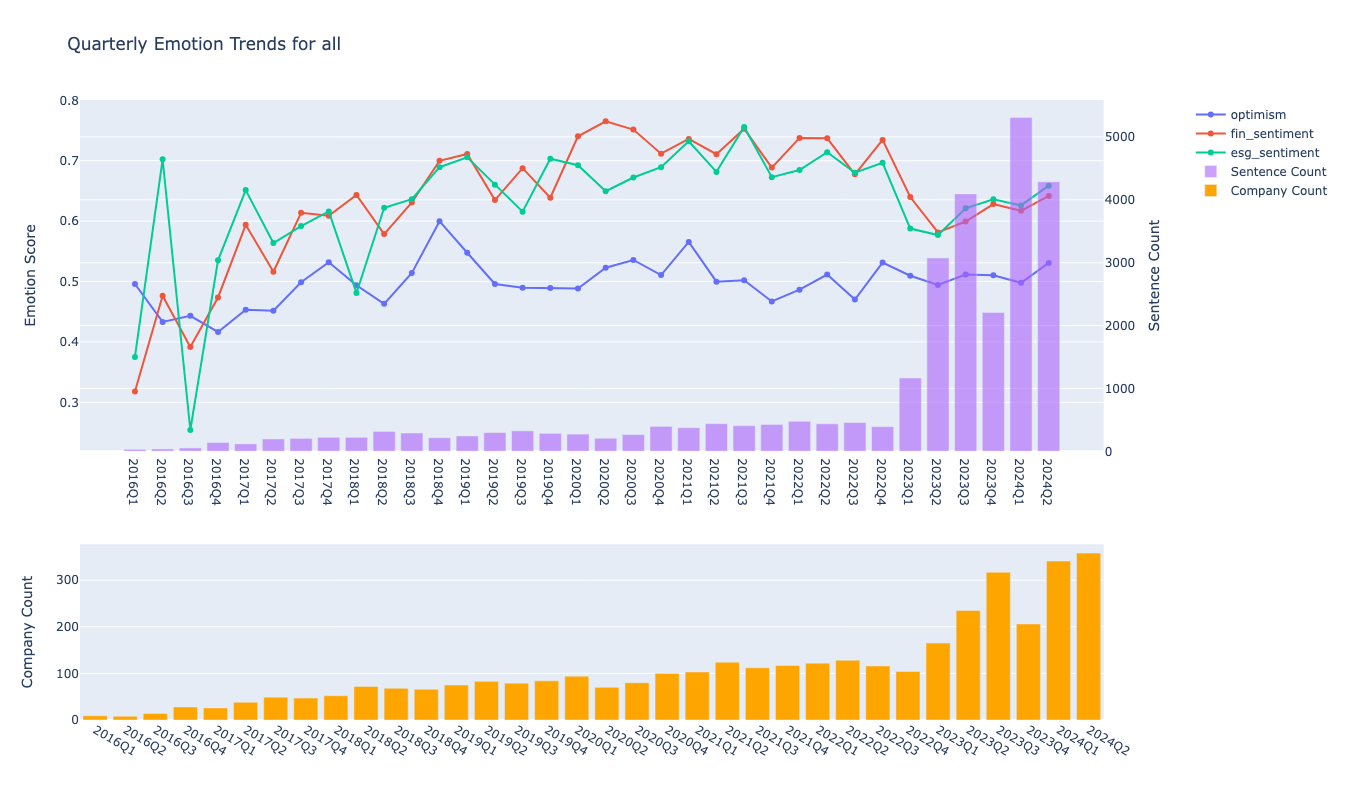

In [15]:
metrics = [
       'emotions.optimism',
       'analysis.fin_sentiment','analysis.esg_sentiment'	
       ]

plot_metric_and_sentence_trends(events_by_quarter, metrics, show_company_count=True)

The graph above illustrates the changes in AI mentions and the associated optimism, financial, and ESG sentiments over time. It shows a gradual increase in the number of AI mentions, rising from just 32 in 2016 to 393 by the fourth quarter of 2022. However, following the public release of ChatGPT and it's advanced models, mentions surged dramatically, tripling to 3076 in the first quarter of 2023. This trend continued into the first quarter of 2024, with AI mentions reaching 5307, approximately 14 times the amount recorded in the fourth quarter of 2022. This growth can be attributed not only to the increased frequency of AI mentions but also to a rise in the number of companies focusing on AI, as indicated by the second bar plot. Interestingly, despite the heightened focus on AI, the graph reveals a decline in optimism, as well as a decrease in financial and ESG sentiments, following the rapid increase in AI-related discussions.

In regards to the latter, we also plot the fear and confusion emotions around AI mentions where we observe an increase after the popularization of AI, which might be perhaps explained by the realizations of the issues and the challanges of wider AI adoption.

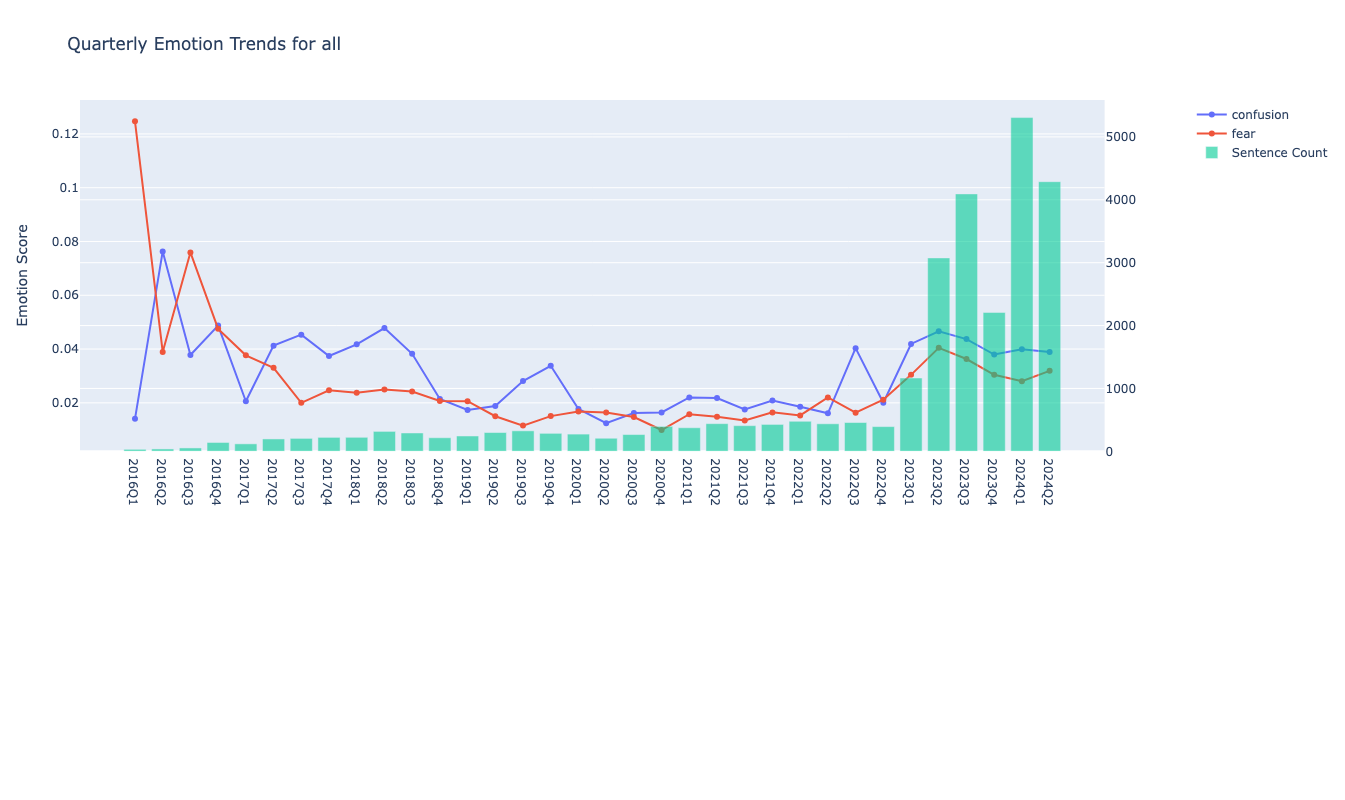

In [16]:
metrics = [
           'emotions.confusion', 'emotions.fear',
       ]

plot_metric_and_sentence_trends(events_by_quarter, metrics)

### Sectoral view of the analysis
Next we dive into the sectoral analysis of the similar trends for which we use our ***group_dataset*** function and group our events data with the sector and the quarter as shown below.

In [17]:
group_cols = ['TRBC Economic Sector Name', 'quarter']
events_by_sector = group_dataset(events_df, group_cols)
events_by_sector

TRBC Economic Sector Name quarter  analysis.fin_sentiment  \
0             Basic Materials  2016Q1               -0.200000   
1      Consumer Non-Cyclicals  2016Q1               -0.067000   
2          Consumer Cyclicals  2016Q1                0.645000   
3                  Technology  2016Q1                0.842308   
4      Consumer Non-Cyclicals  2016Q2                0.040000   
..                        ...     ...                     ...   
270                Financials  2024Q2                0.494128   
271                Healthcare  2024Q2                0.654419   
272               Industrials  2024Q2                0.648856   
273                Technology  2024Q2                0.639883   
274                 Utilities  2024Q2                0.751282   

     analysis.esg_sentiment  emotions.admiration  emotions.anger  \
0                       NaN             0.004286        0.001429   
1                 -0.010000             0.002000        0.000000   
2                  0.000000             0.045000        0.005000   
3                  0.755000             0.045385        0.000769   
4                       NaN             0.000769        0.003077   
..                      ...                  ...             ...   
270                0.625614             0.022844        0.000459   
271                0.601892             0.049380        0.000310   
272                0.611548             0.035425        0.000587   
273                0.660663             0.044959        0.001403   
274                0.603889             0.058718        0.000000   

     emotions.annoyance  emotions.approval  emotions.confusion  \
0              0.064286           0.022857            0.052857   
1              0.015000           0.080000            0.004000   
2              0.010000           0.125000            0.000000   
3              0.002308           0.206923            0.003077   
4              0.024615           0.028462            0.089231   
..                  ...                ...                 ...   
270            0.016972           0.200367            0.074679   
271            0.006899           0.289070            0.020775   
272            0.016716           0.196041            0.044457   
273            0.014816           0.220990            0.036965   
274            0.031282           0.184359            0.030769   

     emotions.disappointment  emotions.disapproval  emotions.fear  \
0                   0.004286              0.005714       0.164286   
1                   0.183000              0.004000       0.280000   
2                   0.090000              0.000000       0.000000   
3                   0.001538              0.003077       0.003077   
4                   0.212308              0.025385       0.103077   
..                       ...                   ...            ...   
270                 0.004220              0.008349       0.045229   
271                 0.030930              0.006512       0.017674   
272                 0.010557              0.014311       0.041525   
273                 0.012870              0.011784       0.032092   
274                 0.002821              0.004615       0.020000   

     emotions.gratitude  emotions.optimism  emotions.pride  emotions.surprise  \
0              0.001429           0.231429        0.000000           0.000000   
1              0.005000           0.420000        0.021000           0.000000   
2              0.005000           0.325000        0.210000           0.020000   
3              0.001538           0.723077        0.073846           0.000000   
4              0.001538           0.153077        0.003077           0.003077   
..                  ...                ...             ...                ...   
270            0.003303           0.447615        0.026239           0.003394   
271            0.003953           0.572248        0.058217           0.001938   
272            0.005601           0.509179        0.047

First, let's plot the sectoral distributaion of the frequency of AI mentions in the transcripts alongside with the distribution of the specific emotion or sentiment.

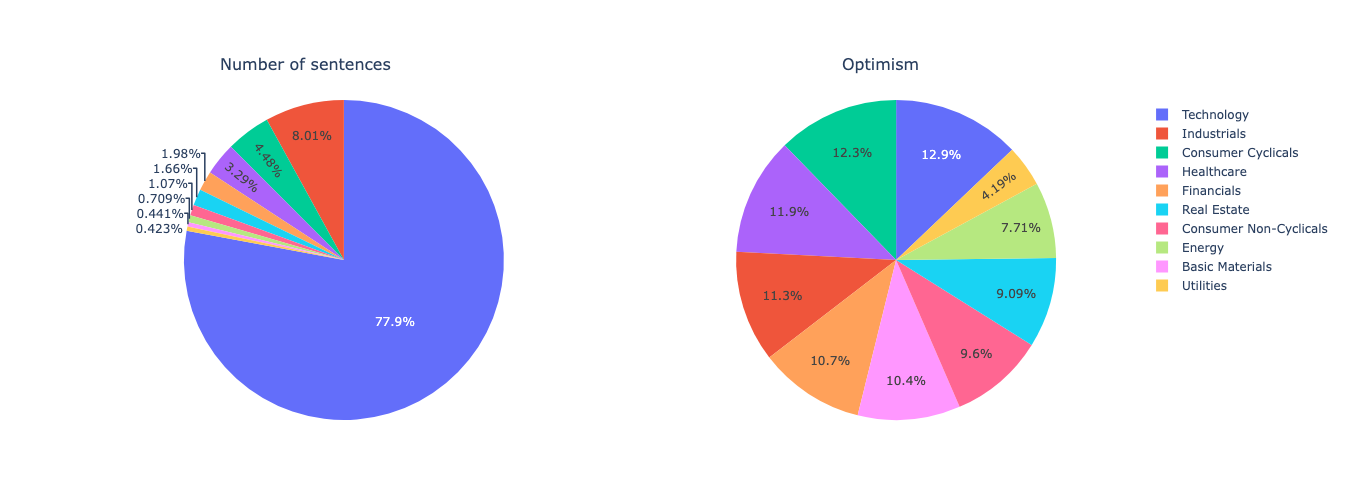

In [18]:
plot_sectoral_analysis(events_by_sector, 'emotions.optimism')

As expected, the technology sector is the primary driver of AI development and the most optimistic about it. Companies in consumer cyclical, healthcare, financials, and industrials are also highly optimistic, while the utilities and energy sectors are the least enthusiastic about AI. While you can experiment with various emotions and sentiments here, below we demonstarte an area plot to show how the emotions/sentiments across different sectors evolved over time.

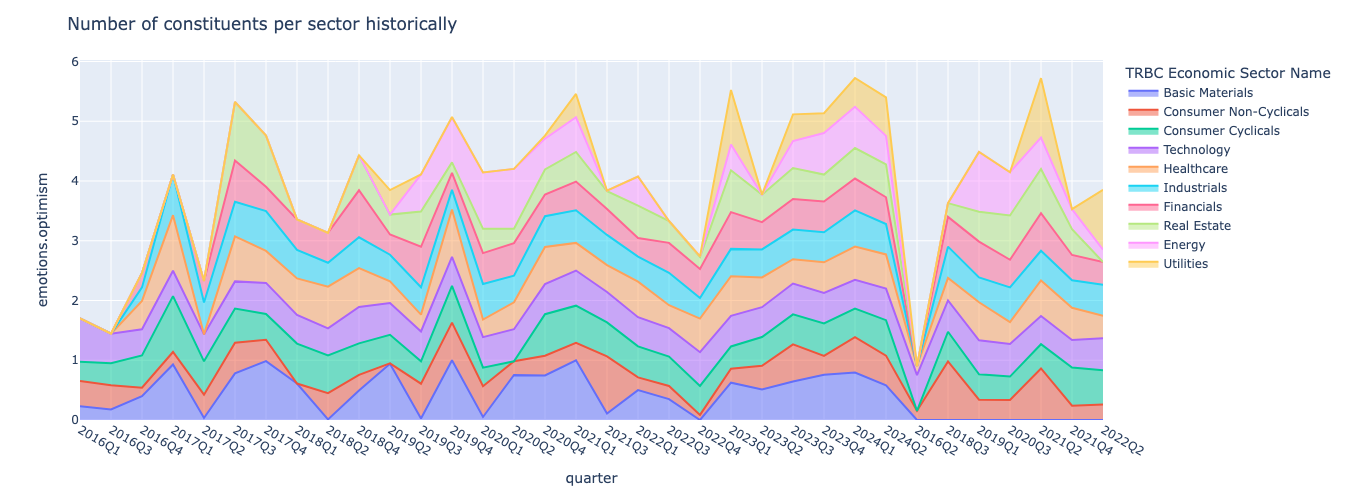

In [19]:
plot_sector_area_trend(events_by_sector, 'emotions.optimism')

Finally, we select a sector and show the number of sentences, companies and emotional shifts within the sector utilizing the ***plot_metric_and_sentence_trends*** function.

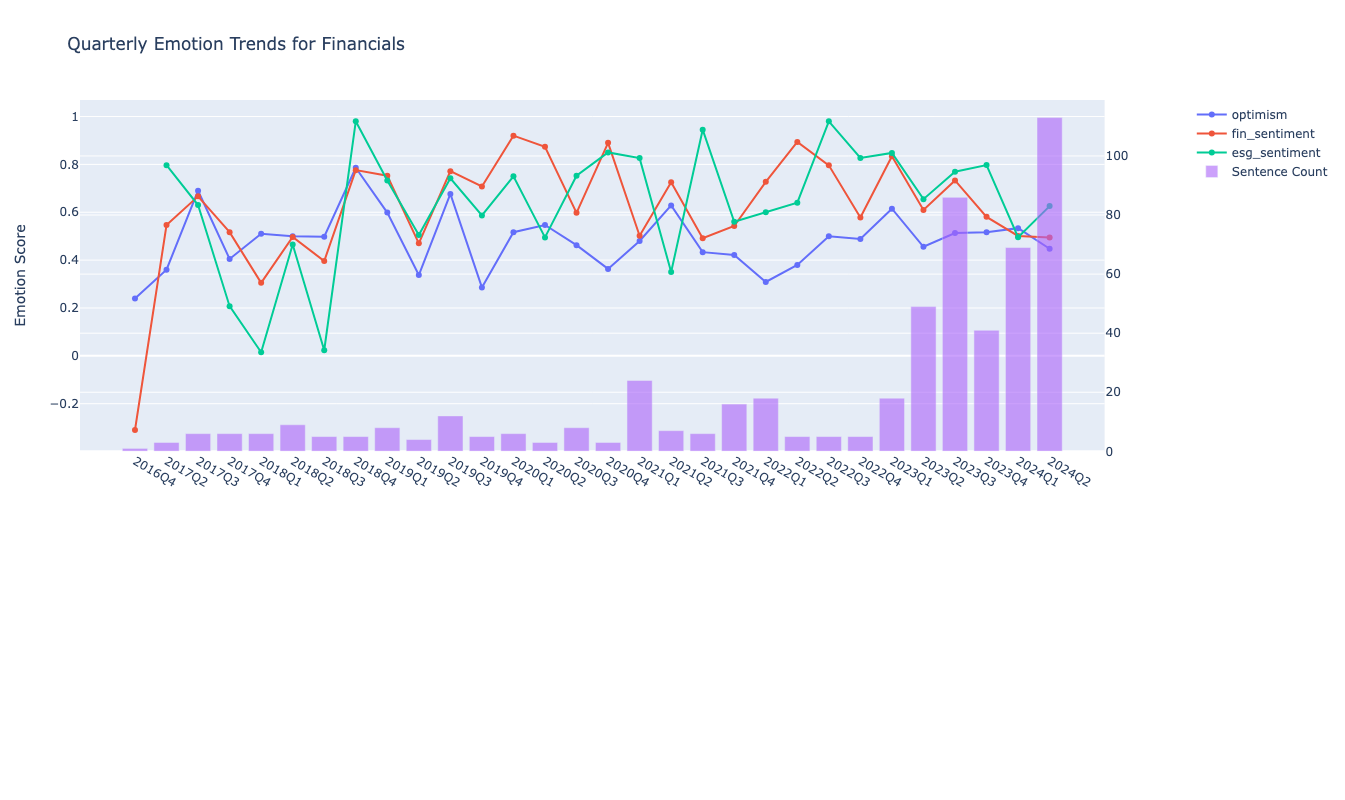

In [20]:
sector = 'Financials'
data  = events_by_sector[events_by_sector['TRBC Economic Sector Name'] == sector]
metrics = [
       'emotions.optimism',
       'analysis.fin_sentiment','analysis.esg_sentiment']

plot_metric_and_sentence_trends(data, metrics, name= sector)

### Company level view of the analysis
Here, we show also the company level view of the analysis, first by grouping events dataset by Instrument and the quarter.

In [21]:
group_cols = ['Instrument', 'quarter', 'start_date']
events_by_company = group_dataset(events_df, group_cols)
events_by_company

Instrument quarter start_date  analysis.fin_sentiment  \
0        MAT.OQ  2016Q1 2016-02-01                0.920000   
1       NVDA.OQ  2016Q1 2016-02-17                0.945000   
2       META.OQ  2016Q1 2016-01-27                0.764286   
3       GOOG.OQ  2016Q1 2016-02-01                0.926667   
4         CCL.N  2016Q1 2016-03-30                0.370000   
...         ...     ...        ...                     ...   
3691     MDB.OQ  2024Q2 2024-05-30                0.552500   
3692    CERT.OQ  2024Q2 2024-05-07                0.943333   
3693      MCO.N  2024Q2 2024-05-02                0.181667   
3694    CDNS.OQ  2024Q2 2024-04-22                0.688413   
3695      HPQ.N  2024Q2 2024-05-29                0.719767   

      analysis.esg_sentiment  emotions.admiration  emotions.anger  \
0                        NaN             0.080000        0.010000   
1                        NaN             0.055000        0.000000   
2                   0.755000             0.005714        0.001429   
3                        NaN             0.113333        0.000000   
4                   0.000000             0.010000        0.000000   
...                      ...                  ...             ...   
3691                0.731667             0.011389        0.000278   
3692                0.803333             0.056667        0.000000   
3693                0.480000             0.005000        0.001667   
3694                0.559459             0.022698        0.001111   
3695                0.811053             0.013488        0.001860   

      emotions.annoyance  emotions.approval  emotions.confusion  \
0               0.010000           0.010000            0.000000   
1               0.005000           0.005000            0.000000   
2               0.002857           0.367143            0.001429   
3               0.000000           0.003333            0.006667   
4               0.010000           0.240000            0.000000   
...                  ...                ...                 ...   
3691            0.015278           0.188056            0.020833   
3692            0.000000           0.356667            0.003333   
3693            0.001667           0.203333            0.103333   
3694            0.011111           0.202222            0.021746   
3695            0.003256           0.266744            0.016512   

      emotions.disappointment  emotions.disapproval  emotions.fear  \
0                    0.000000              0.000000       0.000000   
1                    0.000000              0.005000       0.000000   
2                    0.002857              0.001429       0.000000   
3                    0.000000              0.006667       0.013333   
4                    0.180000              0.000000       0.000000   
...                       ...                   ...            ...   
3691                 0.006389              0.025278       0.044444   
3692                 0.006667              0.000000       0.000000   
3693                 0.003333              0.003333       0.048333   
3694                 0.024603              0.005238       0.040635   
3695                 0.002791              0.002093       0.020465   

      emotions.gratitude  emotions.optimism  emotions.pride  \
0               0.000000           0.640000        0.410000   
1               0.000000           0.615000        0.150000   
2               0.001429           0.605714        0.081429   
3               0.000000           0.990000        0.030000   
4               0.010000           0.010000        0.010000   
...                  ...                ...             ...   
3691            0.002778           0.580556        0.022222   
3692            0.003333           0.630000        0.000000   
3693            0.001667           0.268333        0.000000   
3694            0.004762           0.444127        0.083651   
3695            0.009070           0.592791        0.069070   

      emotions.surprise  emo

First, let's look into the some of the emotions and sentiments for the top 10 companies by the number of AI mentions in the first quarter of 20224.

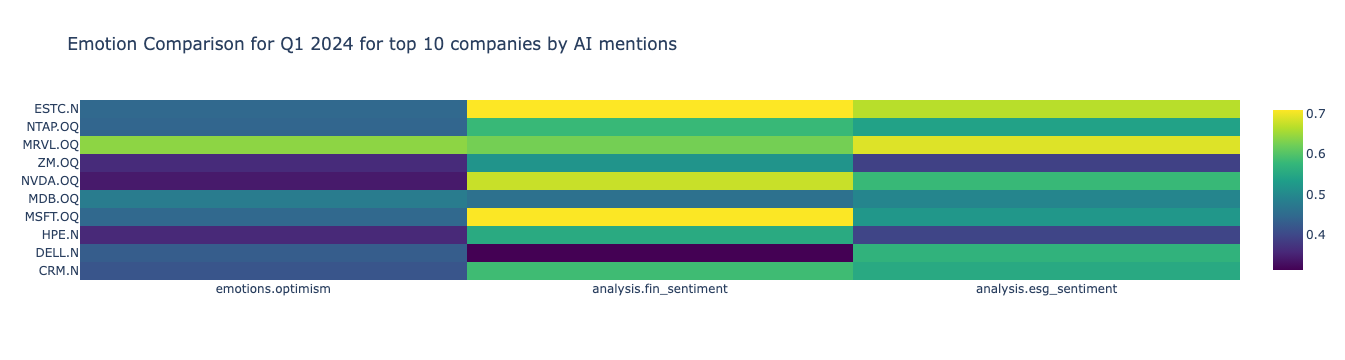

In [22]:
filtered_df = events_by_company[events_by_company['quarter'] == '2024Q1']
top_companies = filtered_df.nlargest(10, 'num_sentences').set_index('Instrument')
emotions = ['emotions.optimism','analysis.fin_sentiment','analysis.esg_sentiment']
heatmap_data = top_companies[emotions].reset_index()

fig = go.Figure(data=go.Heatmap(
    z=heatmap_data[emotions].values,
    x=emotions,
    y=heatmap_data['Instrument'],
    colorscale='Viridis')
    )

fig.update_layout(title='Emotion Comparison for Q1 2024 for top 10 companies by AI mentions')
fig.show()

According to the graph, Salesforce (CRM.N) has the most AI mentions during 2024Q1, however, it is not the most optimistic company around AI amongst the top 10. Below we demonstrate also how the nmber of mentions, emotions and sentiments changed over time for Salesforce. Please note, that the metrics can be updated if interested in the trends of the rest of the emotions, sentiments and the companies.

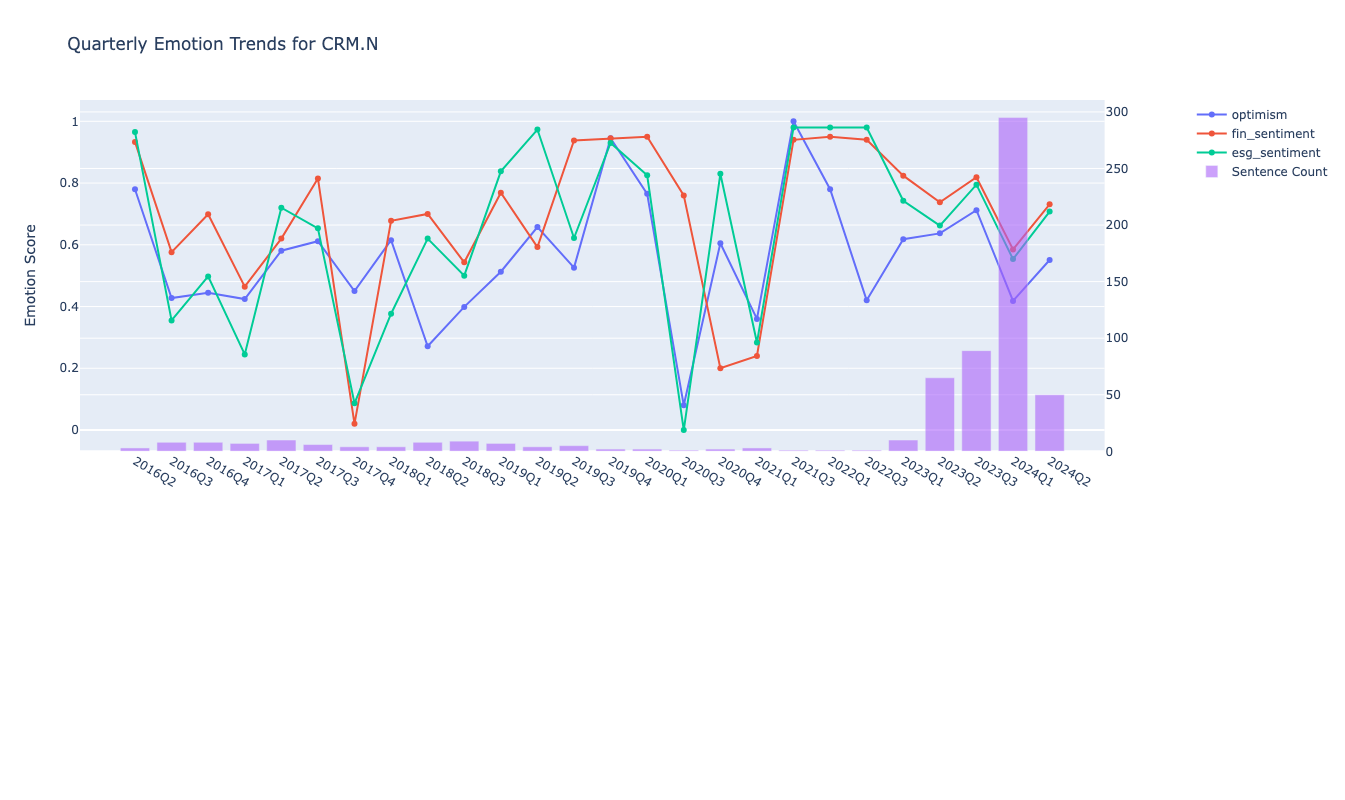

In [23]:
company = 'CRM.N'
data  = events_by_company[events_by_company['Instrument'] == company]
metrics = [       
    'emotions.optimism',
    'analysis.fin_sentiment','analysis.esg_sentiment'
    ]

plot_metric_and_sentence_trends(data, metrics, name = company)

## Section 3: Constructing Thematic Portfolios based on the AI mentions
In this section, we will construct portfolios and track their performance over the analysis period from the first quarter of 2016 to the second quarter of 2024. We employ two approaches for portfolio construction:

*   **Clustering Approach:** In this method, we divide our universe into two clusters based on the number of mentions, emotions, and sentiments.
*   **Quantile-Based Portfolios:** Here, we categorize companies into two quantiles based on a specific metric, which in our case is the number of sentences.

Refer to the relevant sub-section for detailed methodology.

### Getting the pricing data and calculating the returns
We use RD libraries for Python to get the historical close prices for our universe for the analysis period. To track the returns, we calculate the two-month returns of each stock in the portfolios following the event start date. The two-month window is chosen to account for the fact that companies may make announcements on different days throughout the quarter. This approach helps avoid including returns that occur after the subsequent earnings call event date.

Below we find the unique instruments from our event dataset and request close prices for January 2016 to July 2024.

In [24]:
rics  = events_by_company['Instrument'].drop_duplicates().to_list()
prices  = rd.get_history(rics, 'TRDPRC_1', start='2016-01-01', end='2024-07-30')

Next, we define the **calculate_period_returns** function which calculates the percentage returns for stocks over a specified period following an event date.

In [25]:
def calculate_period_returns(event_df: pd.DataFrame, prices_df: pd.DataFrame) -> pd.DataFrame:
    # define helper to calculate percentage change in series
    def calculate_pct_change(series):
        return (series.iloc[-1] - series.iloc[0]) / series.iloc[0] * 100

    returns = []
    end_dates = []
    for row in event_df.itertuples():
        # Define start and end dates for the period
        start = pd.to_datetime(row.start_date) + timedelta(days=1)
        end = start + relativedelta(months=2)
        ric = row.Instrument
        # Filter prices for the given period
        prices_ric = prices_df[ric][(prices_df[ric].index > start) & (prices_df[ric].index <= end)]
        # Calculate percentage change and store results
        returns.append(calculate_pct_change(prices_ric))
        end_dates.append(end)
    
    # Add returns and end dates to event_df
    event_df['returns'] = returns
    event_df['end_date'] = end_dates
    return event_df


events_by_company = calculate_period_returns(events_by_company, prices)
events_by_company

Instrument quarter start_date  analysis.fin_sentiment  \
0        MAT.OQ  2016Q1 2016-02-01                0.920000   
1       NVDA.OQ  2016Q1 2016-02-17                0.945000   
2       META.OQ  2016Q1 2016-01-27                0.764286   
3       GOOG.OQ  2016Q1 2016-02-01                0.926667   
4         CCL.N  2016Q1 2016-03-30                0.370000   
...         ...     ...        ...                     ...   
3691     MDB.OQ  2024Q2 2024-05-30                0.552500   
3692    CERT.OQ  2024Q2 2024-05-07                0.943333   
3693      MCO.N  2024Q2 2024-05-02                0.181667   
3694    CDNS.OQ  2024Q2 2024-04-22                0.688413   
3695      HPQ.N  2024Q2 2024-05-29                0.719767   

      analysis.esg_sentiment  emotions.admiration  emotions.anger  \
0                        NaN             0.080000        0.010000   
1                        NaN             0.055000        0.000000   
2                   0.755000             0.005714        0.001429   
3                        NaN             0.113333        0.000000   
4                   0.000000             0.010000        0.000000   
...                      ...                  ...             ...   
3691                0.731667             0.011389        0.000278   
3692                0.803333             0.056667        0.000000   
3693                0.480000             0.005000        0.001667   
3694                0.559459             0.022698        0.001111   
3695                0.811053             0.013488        0.001860   

      emotions.annoyance  emotions.approval  emotions.confusion  \
0               0.010000           0.010000            0.000000   
1               0.005000           0.005000            0.000000   
2               0.002857           0.367143            0.001429   
3               0.000000           0.003333            0.006667   
4               0.010000           0.240000            0.000000   
...                  ...                ...                 ...   
3691            0.015278           0.188056            0.020833   
3692            0.000000           0.356667            0.003333   
3693            0.001667           0.203333            0.103333   
3694            0.011111           0.202222            0.021746   
3695            0.003256           0.266744            0.016512   

      emotions.disappointment  emotions.disapproval  emotions.fear  \
0                    0.000000              0.000000       0.000000   
1                    0.000000              0.005000       0.000000   
2                    0.002857              0.001429       0.000000   
3                    0.000000              0.006667       0.013333   
4                    0.180000              0.000000       0.000000   
...                       ...                   ...            ...   
3691                 0.006389              0.025278       0.044444   
3692                 0.006667              0.000000       0.000000   
3693                 0.003333              0.003333       0.048333   
3694                 0.024603              0.005238       0.040635   
3695                 0.002791              0.002093       0.020465   

      emotions.gratitude  emotions.optimism  emotions.pride  \
0               0.000000           0.640000        0.410000   
1               0.000000           0.615000        0.150000   
2               0.001429           0.605714        0.081429   
3               0.000000           0.990000        0.030000   
4               0.010000           0.010000        0.010000   
...                  ...                ...             ...   
3691            0.002778           0.580556        0.022222   
3692            0.003333           0.630000        0.000000   
3693            0.001667           0.268333        0.000000   
3694            0.004762           0.444127        0.083651   
3695            0.009070           0.592791        0.069070   

      emotions.surprise  emo

### Portfolio Construction Approach 1: Clusttering our universe
At this step, we will cluster our universe into two groups using the KMeans algorithm, based on mentions, sentiments, and emotions as input features. The clustering is performed separately for each quarter to prevent look-ahead bias, ensuring that only data available up to that point in time is used for clustering.

The **cluster_companies** function below groups companies by quarter and then clusters them based on the provided features.

In [26]:
def cluster_companies(df:pd.DataFrame, features:list) ->tuple[pd.DataFrame, list]:
    def cluster_group(group):
        # Fill missing values (kmeans can't handle NaNs) and scale features
        for col in features:
            group[col] = group[col].fillna(0)
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(group[features])
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=2, random_state=42)
        group['cluster'] = kmeans.fit_predict(scaled_features)
        return group, kmeans.cluster_centers_

    clustered_df = pd.DataFrame()
    cluster_centers = []

    # Group by quarter and apply clustering
    for quarter, group in df.groupby('quarter'):
        clustered_group, centers = cluster_group(group)
        clustered_df = pd.concat([clustered_df, clustered_group])
        cluster_centers.append({quarter: centers})

    return clustered_df, cluster_centers


In [27]:
features = [
        'analysis.fin_sentiment', 'analysis.esg_sentiment','emotions.admiration', 
        'emotions.anger', 'emotions.annoyance', 'emotions.approval', 
        'emotions.confusion', 'emotions.disappointment', 'emotions.disapproval', 
        'emotions.fear', 'emotions.gratitude', 'emotions.optimism', 
        'emotions.pride', 'emotions.surprise', 'emotions.neutral', 
        'num_sentences'
]

events_by_company, cluster_means = cluster_companies(events_by_company, features)
events_by_company

Instrument quarter start_date  analysis.fin_sentiment  \
0        MAT.OQ  2016Q1 2016-02-01                0.920000   
1       NVDA.OQ  2016Q1 2016-02-17                0.945000   
2       META.OQ  2016Q1 2016-01-27                0.764286   
3       GOOG.OQ  2016Q1 2016-02-01                0.926667   
4         CCL.N  2016Q1 2016-03-30                0.370000   
...         ...     ...        ...                     ...   
3691     MDB.OQ  2024Q2 2024-05-30                0.552500   
3692    CERT.OQ  2024Q2 2024-05-07                0.943333   
3693      MCO.N  2024Q2 2024-05-02                0.181667   
3694    CDNS.OQ  2024Q2 2024-04-22                0.688413   
3695      HPQ.N  2024Q2 2024-05-29                0.719767   

      analysis.esg_sentiment  emotions.admiration  emotions.anger  \
0                   0.000000             0.080000        0.010000   
1                   0.000000             0.055000        0.000000   
2                   0.755000             0.005714        0.001429   
3                   0.000000             0.113333        0.000000   
4                   0.000000             0.010000        0.000000   
...                      ...                  ...             ...   
3691                0.731667             0.011389        0.000278   
3692                0.803333             0.056667        0.000000   
3693                0.480000             0.005000        0.001667   
3694                0.559459             0.022698        0.001111   
3695                0.811053             0.013488        0.001860   

      emotions.annoyance  emotions.approval  emotions.confusion  \
0               0.010000           0.010000            0.000000   
1               0.005000           0.005000            0.000000   
2               0.002857           0.367143            0.001429   
3               0.000000           0.003333            0.006667   
4               0.010000           0.240000            0.000000   
...                  ...                ...                 ...   
3691            0.015278           0.188056            0.020833   
3692            0.000000           0.356667            0.003333   
3693            0.001667           0.203333            0.103333   
3694            0.011111           0.202222            0.021746   
3695            0.003256           0.266744            0.016512   

      emotions.disappointment  emotions.disapproval  emotions.fear  \
0                    0.000000              0.000000       0.000000   
1                    0.000000              0.005000       0.000000   
2                    0.002857              0.001429       0.000000   
3                    0.000000              0.006667       0.013333   
4                    0.180000              0.000000       0.000000   
...                       ...                   ...            ...   
3691                 0.006389              0.025278       0.044444   
3692                 0.006667              0.000000       0.000000   
3693                 0.003333              0.003333       0.048333   
3694                 0.024603              0.005238       0.040635   
3695                 0.002791              0.002093       0.020465   

      emotions.gratitude  emotions.optimism  emotions.pride  \
0               0.000000           0.640000        0.410000   
1               0.000000           0.615000        0.150000   
2               0.001429           0.605714        0.081429   
3               0.000000           0.990000        0.030000   
4               0.010000           0.010000        0.010000   
...                  ...                ...             ...   
3691            0.002778           0.580556        0.022222   
3692            0.003333           0.630000        0.000000   
3693            0.001667           0.268333        0.000000   
3694            0.004762           0.444127        0.083651   
3695            0.009070           0.592791        0.069070   

      emotions.surprise  emo

Below we plot the cluster centers for the last quarter of the analysis to identify the cluster patterns.

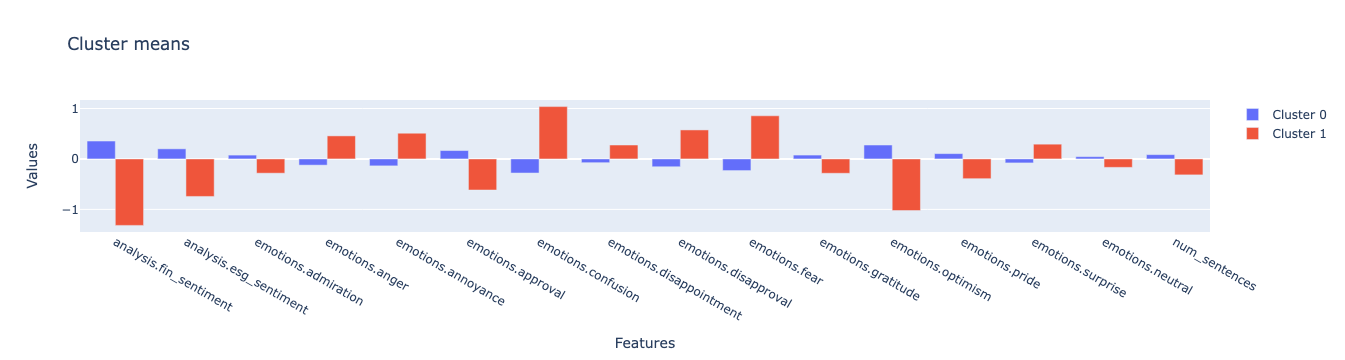

In [28]:
fig = go.Figure(data=[
    go.Bar(name='Cluster 0', x=features, y=list(cluster_means[-1].values())[0][0]),
    go.Bar(name='Cluster 1', x=features, y=list(cluster_means[-1].values())[0][1])
])

fig.update_layout(barmode='group', title='Cluster means',
                  xaxis_title='Features', yaxis_title='Values')

fig.show()

As shown in the plot above, Cluster 0 has higher means for positive sentiments, emotions, and the number of mentions, while showing lower means for negative emotions. Therefore, we will define Cluster 0 as the "higher mean" cluster and Cluster 1 as the "lower mean" cluster for the subsequent portfolio analysis.

### Portfolio Construction Approach 2: Assigning quantiles to the Universe
In this step, we will devide our quarterly universe into 2 quantiles based on a metric, e.g the number of sentences.

Below, we first define our metric and use ***compute_quantiles_per_quarter*** function which categorizes data into quantiles for each quarter based on a specified metric column. 

In [29]:
metric = 'num_sentences'

In [30]:
def compute_quantiles_per_quarter(df: pd.DataFrame, sentiment_column: str) -> pd.DataFrame:
    def preprocess_sentiment(x):
        # Add a small random noise to avoid ties in quantile calculation
        noise = np.random.normal(0, 1e-9, len(x))
        return x + noise
    
    def calculate_quartiles(x):
        try:
            x = preprocess_sentiment(x)
            # Compute quartiles
            return pd.qcut(x, 2, labels=False) + 1
        except ValueError:
            # Handle cases with insufficient data
            return pd.Series(np.nan, index=x.index)
    
    # Apply quantile calculation within each quarter
    df['quantile'] = df.groupby('quarter')[sentiment_column].transform(calculate_quartiles)
    
    return df

events_by_company = compute_quantiles_per_quarter(events_by_company, metric)
events_by_company

Instrument quarter start_date  analysis.fin_sentiment  \
0        MAT.OQ  2016Q1 2016-02-01                0.920000   
1       NVDA.OQ  2016Q1 2016-02-17                0.945000   
2       META.OQ  2016Q1 2016-01-27                0.764286   
3       GOOG.OQ  2016Q1 2016-02-01                0.926667   
4         CCL.N  2016Q1 2016-03-30                0.370000   
...         ...     ...        ...                     ...   
3691     MDB.OQ  2024Q2 2024-05-30                0.552500   
3692    CERT.OQ  2024Q2 2024-05-07                0.943333   
3693      MCO.N  2024Q2 2024-05-02                0.181667   
3694    CDNS.OQ  2024Q2 2024-04-22                0.688413   
3695      HPQ.N  2024Q2 2024-05-29                0.719767   

      analysis.esg_sentiment  emotions.admiration  emotions.anger  \
0                   0.000000             0.080000        0.010000   
1                   0.000000             0.055000        0.000000   
2                   0.755000             0.005714        0.001429   
3                   0.000000             0.113333        0.000000   
4                   0.000000             0.010000        0.000000   
...                      ...                  ...             ...   
3691                0.731667             0.011389        0.000278   
3692                0.803333             0.056667        0.000000   
3693                0.480000             0.005000        0.001667   
3694                0.559459             0.022698        0.001111   
3695                0.811053             0.013488        0.001860   

      emotions.annoyance  emotions.approval  emotions.confusion  \
0               0.010000           0.010000            0.000000   
1               0.005000           0.005000            0.000000   
2               0.002857           0.367143            0.001429   
3               0.000000           0.003333            0.006667   
4               0.010000           0.240000            0.000000   
...                  ...                ...                 ...   
3691            0.015278           0.188056            0.020833   
3692            0.000000           0.356667            0.003333   
3693            0.001667           0.203333            0.103333   
3694            0.011111           0.202222            0.021746   
3695            0.003256           0.266744            0.016512   

      emotions.disappointment  emotions.disapproval  emotions.fear  \
0                    0.000000              0.000000       0.000000   
1                    0.000000              0.005000       0.000000   
2                    0.002857              0.001429       0.000000   
3                    0.000000              0.006667       0.013333   
4                    0.180000              0.000000       0.000000   
...                       ...                   ...            ...   
3691                 0.006389              0.025278       0.044444   
3692                 0.006667              0.000000       0.000000   
3693                 0.003333              0.003333       0.048333   
3694                 0.024603              0.005238       0.040635   
3695                 0.002791              0.002093       0.020465   

      emotions.gratitude  emotions.optimism  emotions.pride  \
0               0.000000           0.640000        0.410000   
1               0.000000           0.615000        0.150000   
2               0.001429           0.605714        0.081429   
3               0.000000           0.990000        0.030000   
4               0.010000           0.010000        0.010000   
...                  ...                ...             ...   
3691            0.002778           0.580556        0.022222   
3692            0.003333           0.630000        0.000000   
3693            0.001667           0.268333        0.000000   
3694            0.004762           0.444127        0.083651   
3695            0.009070           0.592791        0.069070   

      emotions.surprise  emo

### Calculating and visualizing the portfolio returns

As already mentioned, we employ two approaches for portfolio construction: one based on quantiles and the other based on clusters. For each approach, we create both equal-weighted and weighted portfolios based on the provided metric. 

The function below calculates and adds weights for each universe per quarter. Note that it requires the event DataFrame, the metric, and the portfolio type as inputs, with the portfolio type being crucial for correct grouping to calculate the weights.

In [31]:
def calculate_weights(df: pd.DataFrame, metric:str = 'num_sentences', portf_type:str = 'quantile')-> pd.DataFrame:
    # Normalize sentiment values if there are any negative values
    if (df[metric] < 0).any():
        scaler = MinMaxScaler()
        df['normalized_sentiment'] = scaler.fit_transform(np.array(df[metric]).reshape(-1, 1))
        metric = 'normalized_sentiment'
    
    # Calculate total sentiment value for each (quarter, cluster) combination
    total_cluster_value = df.groupby(['quarter', portf_type])[metric].transform('sum')
    
    # Compute weights as the ratio of individual sentiment to total cluster sentiment
    df['weight'] = df[metric] / total_cluster_value
    return df

Now, that we have all the necessary components for constructing, rebalancing, and calculating the returns of our portfolios, we define the ***rebalance_portfolio_and_calculate_returns*** function. As the name suggests, this function constructs, rebalances, and calculates portfolios based on the specified portfolio types. It returns detailed portfolio rebalancing results, including information on portfolio assets and returns for each quarter, as well as summary results with only the total number of assets and aggregated returns for each quarter.

In [32]:
def rebalance_portfolio_and_calculate_returns(df: pd.DataFrame, portf_type:str = 'quantile')-> tuple[dict, dict]:
    # Drop rows with missing values in the specified columns
    df = df.dropna(subset=portf_type).dropna(subset='returns')
    
    # Initialize dictionaries for detailed and summary portfolio data
    portf_detailed = {}
    portf_summary = {}
    # Map portfolio types to descriptive names
    portf_name_dict ={'quantile': {1:'lowest quantile', 2:'highest quantile'},
                     'cluster': {0: 'higher mean', 1: 'lower mean'}}
    
    # Process each unique portfolio type
    for portf_name in sorted(df[portf_type].unique()):
        portf_data= df[df[portf_type] == portf_name]
        port_name_key = portf_name_dict[portf_type][portf_name]
        portf_detailed[port_name_key] = []
        portf_summary[port_name_key] = []
        portf_summary['weighted'] = []

        # Process each unique quarter
        for quarter in portf_data['quarter'].astype(str).unique():
            quarter_data = portf_data[portf_data['quarter'] == quarter]
            assets = quarter_data['Instrument'].tolist()
            returns = quarter_data['returns'].tolist()

            # Calculate weighted average returns if portfolio type is 'quantile' and add to the summary dict. Cluster based approach is equal-weighted only
            # if portf_type == 'quantile':
            weights = quarter_data['weight'].tolist()
            weighted_avg_returns = np.dot(returns, weights)
            portf_summary['weighted'].append({
                quarter: {
                    'return': weighted_avg_returns,
                    'n_assets': len(df[df['quarter'] == quarter]['Instrument'].unique())
                }
            })

            # Calculate average returns
            avg_return = np.mean(returns)

            # Store detailed and summary metrics
            portf_detailed[port_name_key].append({
                quarter: {
                    'assets': assets,
                    'returns': returns,
                    'avg_return': avg_return
                }
            })
            portf_summary[port_name_key].append({
                quarter: {
                    'return': avg_return,
                    'n_assets': len(assets)
                }
            })
    return portf_detailed, portf_summary



So, let's now add the weights to our dataset and run the rebalance_portfolio_and_calculate_returns function below for cluster based approach.

In [33]:
portf_type = 'cluster'
events_by_company = calculate_weights(events_by_company, metric, portf_type)
portfolio_detailed_view, portfolio_summary_view = rebalance_portfolio_and_calculate_returns(events_by_company, portf_type)
print('portfolio_names:', list(portfolio_summary_view.keys()))
portfolio_summary_view

portfolio_names: ['higher mean', 'weighted', 'lower mean']


{'higher mean': [{'2016Q1': {'return': 7.816555773905836, 'n_assets': 6}},
  {'2016Q2': {'return': 5.957700314568425, 'n_assets': 1}},
  {'2016Q3': {'return': 0.3250325999746272, 'n_assets': 10}},
  {'2016Q4': {'return': 4.530157076428586, 'n_assets': 27}},
  {'2017Q1': {'return': 0.664402158585572, 'n_assets': 25}},
  {'2017Q2': {'return': 1.4567868466435603, 'n_assets': 8}},
  {'2017Q3': {'return': 5.329293686009922, 'n_assets': 39}},
  {'2017Q4': {'return': 3.058630150894592, 'n_assets': 26}},
  {'2018Q1': {'return': -0.6940007730958399, 'n_assets': 49}},
  {'2018Q2': {'return': 3.5879140665843767, 'n_assets': 53}},
  {'2018Q3': {'return': -5.1956197820998415, 'n_assets': 29}},
  {'2018Q4': {'return': -2.996744060385849, 'n_assets': 4}},
  {'2019Q1': {'return': 6.7169795675636585, 'n_assets': 73}},
  {'2019Q2': {'return': 2.8162164406809342, 'n_assets': 35}},
  {'2019Q3': {'return': -1.2243359064464499, 'n_assets': 75}},
  {'2019Q4': {'return': 7.42952935682318, 'n_assets': 45}},
  

The dictionary above contains information about the returns and number of assets per quarter for each portfolio. Below, we define ***summarize_results_by*** function, which transforms the portfolio_summary_view dictionary into a dataframe for subsequent visualisation of the results.

In [34]:
def summarize_results_by(portfolio_summary:dict, port_name:str, by:str) -> pd.DataFrame:
    df = pd.DataFrame()
    # Iterate through each key in the portfolio summary
    for key in portfolio_summary.keys():
        key_df = pd.DataFrame(portfolio_summary[key])
        
        # Extract diagonal values and the relevant data
        diagonal_values = np.diag(key_df)
        data = [ret[by] for ret in diagonal_values]
        
        # Create a new DataFrame with extracted data
        new_df = pd.DataFrame([data], columns=key_df.columns)
        new_df[port_name] = key
        
        # Concatenate new data to the main DataFrame
        df = pd.concat([df, new_df])
    
    # Set the specified portfolio name as the index
    df = df.set_index(port_name)
    
    return df

Further, we run this function for the number of assets and returns (with cumulative sums applied to returns) to have the respective dataframes

In [35]:
assets = summarize_results_by(portfolio_summary_view, portf_type, 'n_assets').T
rets =  summarize_results_by(portfolio_summary_view, portf_type, 'return').T.cumsum()
rets

cluster  higher mean   weighted  lower mean
2016Q1      7.816556   8.010933    2.968702
2016Q2     13.774256  18.647302    8.237119
2016Q3     14.099289  16.295423    6.863850
2016Q4     18.629446  23.759538   14.327965
2017Q1     19.293848  22.998760   13.567188
2017Q2     20.750635  28.633113   15.458191
2017Q3     26.079928  33.796175   16.888627
2017Q4     29.138559  36.622508   19.423301
2018Q1     28.444558  27.008255   11.411424
2018Q2     32.032472  30.161117   12.797227
2018Q3     26.836852  23.796202   10.372580
2018Q4     23.840108  22.488202    7.493018
2019Q1     30.557088  18.223534    3.228351
2019Q2     33.373304  22.166002    6.839226
2019Q3     32.148968  26.384795    9.292842
2019Q4     39.578498  36.632996   15.649747
2020Q1     24.637609  23.860591    2.086658
2020Q2     35.089814  36.265717   12.961493
2020Q3     34.945805  37.769754   13.153963
2020Q4     49.693559  50.738902   26.123111
2021Q1     56.234534  54.485825   31.216281
2021Q2     65.050373  64.299922   40.232320
2021Q3     65.322679  68.583734   38.128231
2021Q4     59.557762  66.540675   35.724302
2022Q1     56.679605  62.257865   31.728757
2022Q2     52.933162  56.073439   27.536494
2022Q3     43.338484  44.492865   15.681191
2022Q4     45.145504  46.261598   17.066174
2023Q1     42.028149  45.560204   14.082347
2023Q2     51.485046  59.865518   26.475360
2023Q3     46.018908  56.705432   20.918625
2023Q4     61.014972  70.387769   35.572904
2024Q1     62.579201  70.912383   37.569839
2024Q2     63.948746  74.617685   40.059552

Finally, we show the cumulative returns along with the number of assets per portfolio over the analysis period.

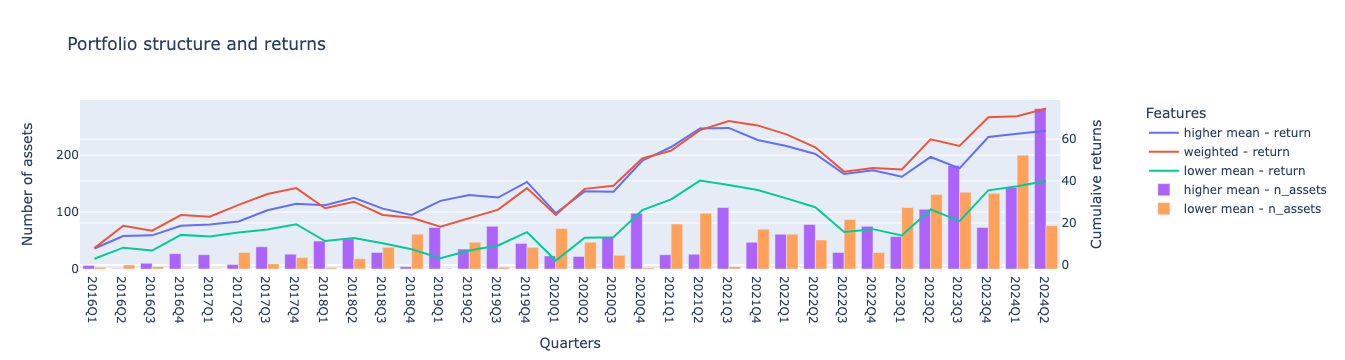

In [36]:
def visulize_results(rets_df:pd.DataFrame, assets_df:pd.DataFrame):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    for col in rets_df.columns:
        fig.add_trace(
            go.Scatter(x=rets_df.index, y=rets_df[col].dropna(), mode='lines', name=f"{col} - return"),
            secondary_y=True,
        )

    for col in assets_df.columns.drop('weighted'):
        fig.add_trace(
            go.Bar(x=assets_df.index, y=assets_df[col], name=f"{col} - n_assets"),
            secondary_y=False,
        )

    fig.update_layout(
        title_text="Portfolio structure and returns",
        xaxis_title="Quarters",
        yaxis_title="Number of assets",
        legend_title="Features"
    )

    fig.update_yaxes(title_text="Number of assets", secondary_y=False)
    fig.update_yaxes(title_text="Cumulaive returns", secondary_y=True)

    fig.show()
visulize_results(rets, assets)

The graph above illustrates the number of assets and returns for each portfolio. The highest cumulative returns are observed in the weighted portfolio, followed by the higher mean portfolio. The lower mean portfolio, which includes companies with lower positive and higher negative emotions, has the lowest returns. Regarding asset allocation, the number of assets in each cluster varies significantly from quarter to quarter. 

Below, we will examine the results for quantile-based portfolios.

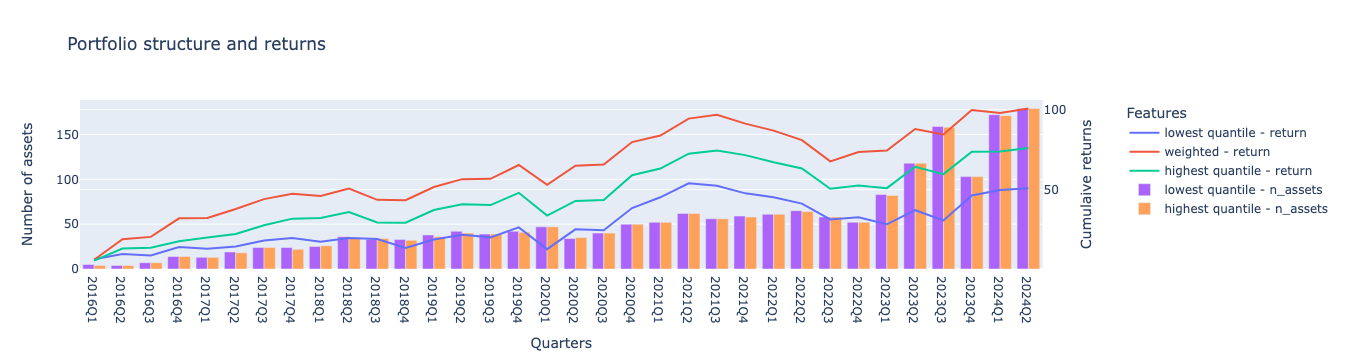

In [37]:
portf_type = 'quantile'
events_by_company = calculate_weights(events_by_company, metric, portf_type)
portfolio_detailed_view, portfolio_summary_view = rebalance_portfolio_and_calculate_returns(events_by_company, portf_type)
assets = summarize_results_by(portfolio_summary_view, portf_type, 'n_assets').T
rets =  summarize_results_by(portfolio_summary_view, portf_type, 'return').T.cumsum()
visulize_results(rets, assets)

The cumulative portfolio returns generally align with the clustering-based approach, with the weighted portfolio having the largest return. The gap between the weighted portfolio and the highest quantiles is significant. Additionally, both the weighted and highest return portfolios outperform the cluster-based weighted and higher mean results. In terms of the number of assets, as expected, the highest and lowest quantile portfolios have an almost equal distribution.

## Final remarks

The article demonstrated how  LSEG MarketPsych Transcripts Analytics (MTA) API can be used to ingest sentences with AI mentions from corporate transcripts and perform exploratory and portfolio construction analysis. The main goal was to examine a. how the frequency and sentiment of AI mentions in earnings calls have evolved over time and per sector and b. to assess whether these patterns can be leveraged to build effective thematic portfolios.

The methodologies and examples presented are primarily intended for educational and exploratory purposes. Although we observed positive results for the constructed thematic portfolios—where portfolios comprised of companies with frequent AI mentions and overall positive sentiments outperformed those with lower rankings—these findings should be considered preliminary insights. They serve as a foundation for further investigation rather than conclusive evidence. Users are encouraged to experiment with different data universes, search terms, and portfolio construction strategies.